## Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
from PIL import Image
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Check Data

In [2]:
test_path = './petfinder-pawpularity-score/test'
train_path = './petfinder-pawpularity-score/train'

test_folders = sorted(glob(test_path + '/*'))
train_folders = sorted(glob(train_path + '/*'))

train_folders[:5]

['./petfinder-pawpularity-score/train\\0007de18844b0dbbb5e1f607da0606e0.jpg',
 './petfinder-pawpularity-score/train\\0009c66b9439883ba2750fb825e1d7db.jpg',
 './petfinder-pawpularity-score/train\\0013fd999caf9a3efe1352ca1b0d937e.jpg',
 './petfinder-pawpularity-score/train\\0018df346ac9c1d8413cfcc888ca8246.jpg',
 './petfinder-pawpularity-score/train\\001dc955e10590d3ca4673f034feeef2.jpg']

(720, 405, 3)


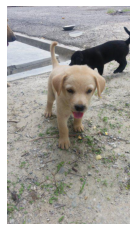

In [4]:
sample_image = train_folders[0]
img = Image.open(sample_image)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

## Preprocessing

In [6]:
df = pd.read_csv('./petfinder-pawpularity-score/train.csv')
display(df.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [7]:
images  = []
targets = []
for train_folder in tqdm(train_folders) :
    img = image.load_img(train_folder, target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    images.append(img)
    target = df[df['Id'] == train_folder.split('\\')[-1].split('.')[0]]['Pawpularity'].values[0]
    targets.append(target)

100%|██████████████████████████████████████████████████████████████████████████████| 9912/9912 [02:08<00:00, 77.09it/s]


In [100]:
X = np.array(images)
print('Train X Shape : ', X.shape)

y = np.array(targets)
print('Train y Shape : ', y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=2021, 
                                                      test_size=0.2, 
                                                      stratify = y)

print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)

Train X Shape :  (9912, 224, 224, 3)
Train y Shape :  (9912,)
X_train shape :  (7929, 224, 224, 3)
X_valid shape :  (1983, 224, 224, 3)
y_train shape :  (7929,)
y_valid shape :  (1983,)


In [101]:
print(X_train.shape)
y_train = y_train.reshape(-1,1)
print(y_train)

(7929, 224, 224, 3)
[[26]
 [42]
 [23]
 ...
 [28]
 [25]
 [61]]


In [134]:
baseModel = VGG16(weights='imagenet', include_top=False)
baseModel.trainable = False



model_in = Input(shape = (224,224,3))
base_model = baseModel(model_in)
# head_model = AveragePooling2D(pool_size=(7, 7))(base_model)
head_model = Flatten(name="flatten")(base_model)
head_model = Dense(2048, activation="relu")(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Dense(1024, activation="relu")(head_model)
head_model = Dropout(0.4)(head_model)
model_out = Dense(1, activation="linear")(head_model)
# model_out = Activation("linear_regression")(head_model)

model = Model(inputs=model_in, outputs=model_out)

model.compile(loss='mse',optimizer='Adam',metrics=['mse'])

model.summary()

ResourceExhaustedError: ignored

In [126]:
import gc
gc.collect()

0

In [ ]:
model.fit(X_train, y_train, 
          validation_data = (X_valid, y_valid.reshape(-1,1)),
          epochs=30,
          verbose = 1,
          batch_size=32)

In [119]:
predictions = []
# print(X_train)
for i in range(5):
  predictions.append(np.mean(model.predict(X_train[0 + i:1 + i])))

# for test_image in tqdm(test_images, total = len(test_images)) : 
#     prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
#     predictions.append(prediction)

In [122]:
print(predictions)
print(y_train[:5].ravel())

[21.441246, 37.986885, 32.878345, 28.079079, 31.103014]
[26 42 23 17 28]


In [ ]:
df2 = pd.read_csv('./petfinder-pawpularity-score/train.csv')
display(df.head())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Subject Focus'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Subject Focus'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Eyes'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Eyes'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Face'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Face'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Near'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Near'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Action'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Action'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Accessory'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Accessory'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Group'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Group'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Collage'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Collage'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Human'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Human'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Occlusion'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Occlusion'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Info'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Info'].mean())
print()
display(df.loc[df['Pawpularity'] <= 10, :]['Blur'].mean())
display(df.loc[df['Pawpularity'] >= 90, :]['Blur'].mean())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


0.03209876543209877

0.02278481012658228

0.7333333333333333

0.7417721518987341

0.8839506172839506

0.8911392405063291

0.8716049382716049

0.8784810126582279

0.009876543209876543

0.012658227848101266

0.04197530864197531

0.060759493670886074

0.16049382716049382

0.10886075949367088

0.056790123456790124

0.043037974683544304

0.1728395061728395

0.1518987341772152

0.1654320987654321

0.13924050632911392

0.06419753086419754

0.05822784810126582

0.08888888888888889

0.07088607594936709